In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
import qiskit as qiskit
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, transpile, Aer, IBMQ

import ramsey_experiment

# Loading your IBM Quantum account(s)
IBMQ.save_account(os.environ.get('IBM_KEY'), overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')



C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
ibmqfactory.load_account:WARNING:2024-01-09 09:43:13,081: Credentials are already in use. The existing account in the session will be replaced.


In [2]:
h = lambda n, J, z: sum([J[i] * (z[i] - 1) * (z[(i + 1) % n] - 1) for i in range(n - 1)])


def effective_hem(size, J, W):
    hem = np.zeros((2 ** size, 2 ** size))
    for i in range(2 ** size):
        binary = '{0:b}'.format(i).zfill(size)
        Z = [(-1) ** int(i) for i in binary]
        #Z.reverse()
        hem[i, i] = h(size, J, Z)
        hem[i, i] += sum([W[k] for k in range(size) if binary[k] == '1'])
    return hem

J =  [2.9739543133539224, 3.092457469378227, 3.273390258335254, 3.8340232074800005]
W =  [3, 3, 3, 3, 3]


C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


0.0
0.09519977738150888
0.19039955476301776
0.28559933214452665
0.3807991095260355
0.4759988869075444
0.5711986642890533
0.6663984416705622
0.761598219052071
0.8567979964335799
0.9519977738150888
1.0471975511965976
1.1423973285781066
1.2375971059596154
1.3327968833411243
1.427996660722633
1.523196438104142
1.618396215485651
1.7135959928671598
1.8087957702486688
1.9039955476301775
1.9991953250116865
2.0943951023931953
2.1895948797747042
2.284794657156213
2.379994434537722
2.4751942119192307
2.5703939893007397
2.6655937666822487
2.7607935440637577
2.855993321445266
2.951193098826775
3.046392876208284
3.141592653589793
3.236792430971302
3.3319922083528106
3.4271919857343196
3.5223917631158286
3.6175915404973376
3.712791317878846
3.807991095260355
3.903190872641864
3.998390650023373
4.093590427404882
4.1887902047863905
4.2839899821679
4.3791897595494085
4.474389536930917
4.569589314312426
4.664789091693935
4.759988869075444
4.855188646456953
4.9503884238384614
5.045588201219971
5.140787978

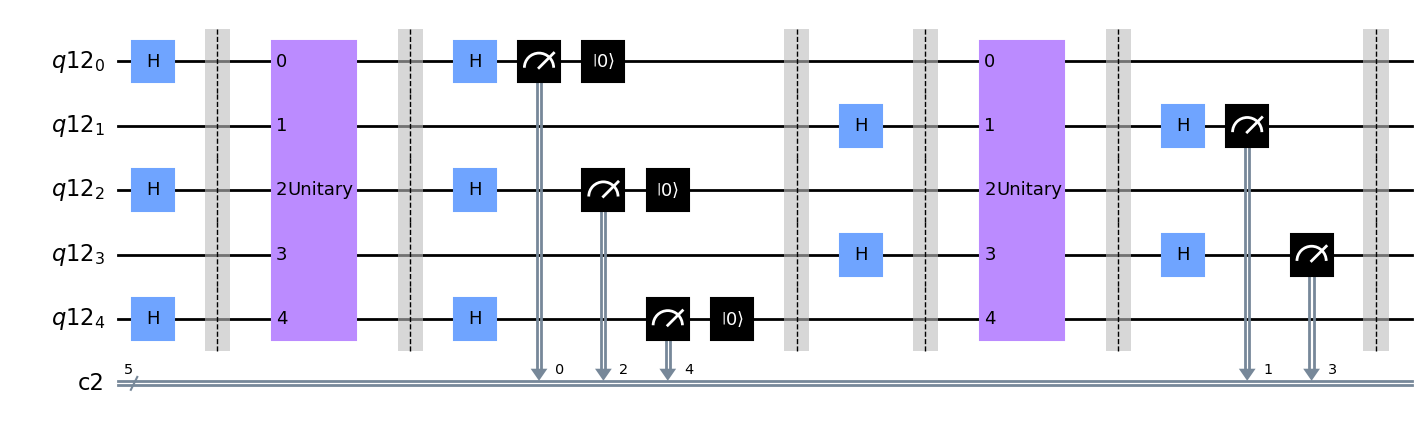

In [5]:
import Ramsey_ExperimentV2
import random
import importlib

ramsey_experiment = importlib.reload(Ramsey_ExperimentV2)
RamseyExperiment = ramsey_experiment.RamseyExperiment
RamseyBatch = ramsey_experiment.RamseyBatch

n = 5
T = 3 * np.pi

W = [random.gauss(3, 1) for _ in range(n)]
L = [random.gauss(1, 1) for _ in range(n)]
J = [random.gauss(3, 1) for _ in range(n - 1)]

L = [0, 1, 2, 3, 6]
W = [3, 3, 3, 3, 3]

# W = [3]
# L = [3]

shots = 1000

print("J = ", J)
print("W = ", W)

noisy_batch = []
regular_batch = []

exp = []
measurements = 100
delay = np.linspace(0, T, measurements)
for t in delay:
    exp = RamseyExperiment(n, t, shots, J, W, L)
    exp.create_circuit_detuning()
    exp.add_noise()
    exp.add_decay()
    noisy_batch.append(exp)

    exp = RamseyExperiment(n, t, shots, J, W, L)
    exp.create_circuit_detuning()
    exp.add_decay()
    regular_batch.append(exp)

    print(t)
ramseyBatch1 = RamseyBatch(noisy_batch)
ramseyBatch2 = RamseyBatch(regular_batch)
noisy_batch[1].circuit.draw(output='mpl')  # 'mpl' for matplotlib drawing

#print(effective_hem(3,J,W))

In [4]:
print(ramseyBatch1.RamseyExperiments[70].result.get_counts())
print(ramseyBatch1.RamseyExperiments[70].W)

print(effective_hem(ramseyBatch1.RamseyExperiments[70].n, ramseyBatch1.RamseyExperiments[70].J,
                    ramseyBatch1.RamseyExperiments[70].W))

{'00001': 3, '10000': 8, '10001': 2, '01000': 9, '00000': 35, '10011': 2, '00100': 12, '01110': 1, '01100': 4, '00010': 6, '00011': 4, '01101': 2, '10110': 1, '01010': 1, '00101': 1, '11000': 2, '01011': 1, '10100': 1, '01001': 2, '10010': 1, '00111': 1, '11100': 1}
[3, 3, 3, 3, 3]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          3.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          3.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... 31.54096209  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         45.80792757
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  58.87837052]]


NameError: name 'delay' is not defined

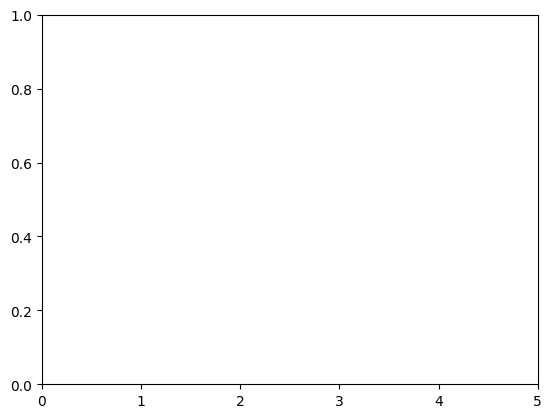

In [4]:
from scipy.ndimage import gaussian_filter

k = 1
#plt.semilogy(delay,y)

plt.xlim([0, 5])
#plt.plot(delay_ext,y_smooth, label='smoothed')
plt.plot(delay,ramseyBatch1.get_zi(k), label='noisy')
plt.plot(delay,ramseyBatch2.get_zi(k), label='regular')

plt.legend()
#plt.plot(delay,y_smooth)

Weighted median frequency: 3.0
var:  -0.003196269126271689


C:\Users\user\AppData\Local\Temp\ipykernel_26092\3904440927.py:52: RuntimeWarning: invalid value encountered in sqrt
  -np.sqrt(
C:\Users\user\AppData\Local\Temp\ipykernel_26092\3904440927.py:54: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(


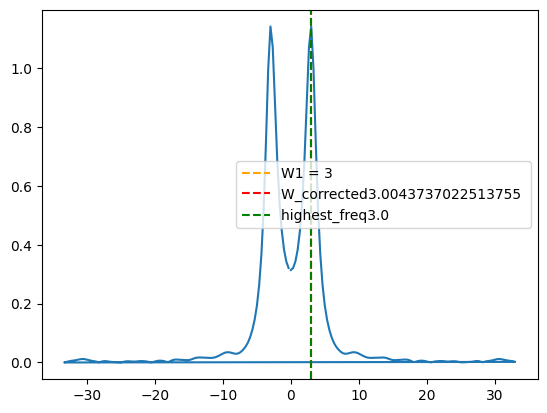

In [191]:
#%matplotlib notebook
from scipy.signal import find_peaks

k = 1

extended = ramseyBatch1.get_zi(k)[::-1]
extended = extended + ramseyBatch1.get_zi(k)
#extended = gaussian_filter(extended, sigma=3)
#apply Hanning window
#extended_w = extended * np.hamming(len(extended))
#extended = gaussian_filter(extended, sigma=0.5)
fft_output_ext = np.fft.fft(extended) / 10

import numpy as np
import matplotlib.pyplot as plt

# Set the sampling rate based on measurements
sample_rate = measurements / T

# Compute the positive frequencies for the FFT output
frequencies_ext = np.fft.fftfreq(len(extended), 1 / sample_rate)

frequencies_ext *= (2 * np.pi)
positive_indices = np.where(frequencies_ext > 0)
positive_magnitudes = np.abs(fft_output_ext)[positive_indices]

frequencies = frequencies_ext[positive_indices]
weights = np.abs(fft_output_ext)[positive_indices]

# Calculating cumulative weights
cumulative_weights = np.cumsum(weights)

# Finding the median position
total_weight = np.sum(weights)
half_total_weight = total_weight / 2

median_index = np.where(cumulative_weights >= half_total_weight)[0][0]
weighted_median_frequency = frequencies[median_index]

print(f'Weighted median frequency: {weighted_median_frequency}')
# Plot and annotate results
plt.plot(frequencies_ext, np.abs(fft_output_ext))
plt.axvline(x=W[k], color='orange', linestyle='--', label=f'W{k} = {W[k]}')
# plt.axvline(x=weighted_median_frequency, color='green', linestyle='--', label=f'W_found{weighted_median_frequency} ')

a = L[k]


highest_freq = frequencies[np.argmax(positive_magnitudes)]

w_solutions = [
    -np.sqrt(
        -a ** 2 / 3 + highest_freq ** 2 / 3 - 2 * np.sqrt(a ** 4 + a ** 2 * highest_freq ** 2 + highest_freq ** 4) / 3),
    np.sqrt(
        -a ** 2 / 3 + highest_freq ** 2 / 3 - 2 * np.sqrt(a ** 4 + a ** 2 * highest_freq ** 2 + highest_freq ** 4) / 3),
    -np.sqrt(
        -a ** 2 / 3 + highest_freq ** 2 / 3 + 2 * np.sqrt(a ** 4 + a ** 2 * highest_freq ** 2 + highest_freq ** 4) / 3),
    np.sqrt(-(a ** 2) / 3 + (highest_freq ** 2) / 3 + 2 * np.sqrt(
        a ** 4 + (a ** 2) * highest_freq ** 2 + highest_freq ** 4) / 3)
]
plt.axvline(x=w_solutions[3], color='red', linestyle='--', label=f'W_corrected{w_solutions[3]} ')

y_lornz = lambda a, x, w: np.pi*(2 * a / (a ** 2 + (x - w) ** 2) + 2 * a / (a ** 2 + (x + w) ** 2))
y_lornz_single = lambda a, x, w: (2 * a / ((a ** 2 + x ** 2)*2*np.pi))

def sinc(x_values):
    X = []
    for x in x_values:
        X.append((np.sin(2*x * np.pi) / (2*x * np.pi) if x != 0 else 1))
    return X

frequencies_ext_sorted = np.sort(frequencies_ext)
Y1 = y_lornz(a, frequencies_ext_sorted, W[k]) * np.sqrt(np.pi)/10
Y2 = sinc(frequencies_ext_sorted)
Y = np.convolve(Y2, Y1, mode='same')

#plt.plot(frequencies_ext_sorted, Y1, label='lorenzian',color='red')

#plt.plot(frequencies_ext_sorted, Y2)

#plt.plot(frequencies_ext_sorted, np.abs(Y), label='theory',color='red')

#variance:
Y3 = y_lornz_single(a, frequencies_ext_sorted, W[k])
squared_x = np.abs(frequencies_ext_sorted)
x2_times_fx = frequencies_ext_sorted * Y3
variance = np.trapz(x2_times_fx, frequencies_ext_sorted)

print("var: ", variance)

#plt.xlim([-30, 30])

plt.axvline(x=highest_freq, color='green', linestyle='--', label=f'highest_freq{highest_freq} ')
#plt.xlim([-20,20])
plt.legend()
plt.show()

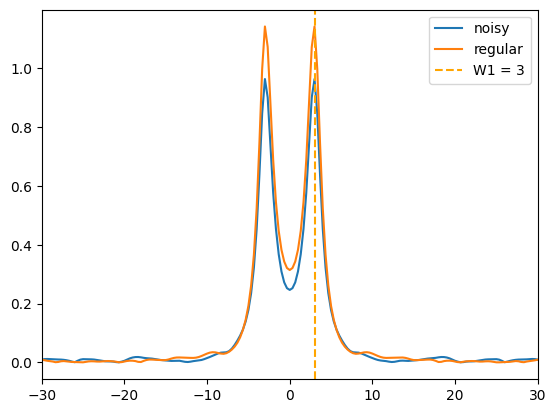

In [244]:
#%matplotlib notebook
from scipy.signal import find_peaks

k = 1

extended1 = ramseyBatch1.get_zi(k)[::-1]
extended1 = extended1 + ramseyBatch1.get_zi(k)

extended2 = ramseyBatch2.get_zi(k)[::-1]
extended2 = extended2 + ramseyBatch2.get_zi(k)

fft_output_ext1 = np.fft.fft(extended1) / 10
fft_output_ext2 = np.fft.fft(extended2) / 10

import numpy as np
import matplotlib.pyplot as plt

# Set the sampling rate based on measurements
sample_rate = measurements / T

# Compute the positive frequencies for the FFT output
frequencies_ext = np.fft.fftfreq(len(extended1), 1 / sample_rate)
frequencies_ext *= (2 * np.pi)

paired = sorted(zip(frequencies_ext, fft_output_ext1))
paired2 = sorted(zip(frequencies_ext, fft_output_ext2))

# Unzipping the pairs
frequencies_ext, fft_output_ext1 = zip(*paired)
frequencies_ext, fft_output_ext2 = zip(*paired2)

plt.plot(frequencies_ext, np.abs(fft_output_ext1), label='noisy')
plt.plot(frequencies_ext, np.abs(fft_output_ext2), label='regular')

plt.axvline(x=W[k], color='orange', linestyle='--', label=f'W{k} = {W[k]}')
plt.legend()
plt.xlim([-30, 30])
#plt.ylim([0,0.1])
plt.show()

In [251]:
print(len(frequencies_ext))
print(np.abs(fft_output_ext)[1100])
print(np.abs(fft_output_ext))

2000
0.012848735040966442
[2.92592741 2.92438691 2.91960857 ... 2.911139   2.91960857 2.92438691]


C:\Users\user\AppData\Local\Temp\ipykernel_26092\499705187.py:53: RuntimeWarning: invalid value encountered in sqrt
  -np.sqrt(-a ** 2 / 3 + highest_freq ** 2 / 3 - 2 * np.sqrt(
C:\Users\user\AppData\Local\Temp\ipykernel_26092\499705187.py:55: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(-a ** 2 / 3 + highest_freq ** 2 / 3 - 2 * np.sqrt(


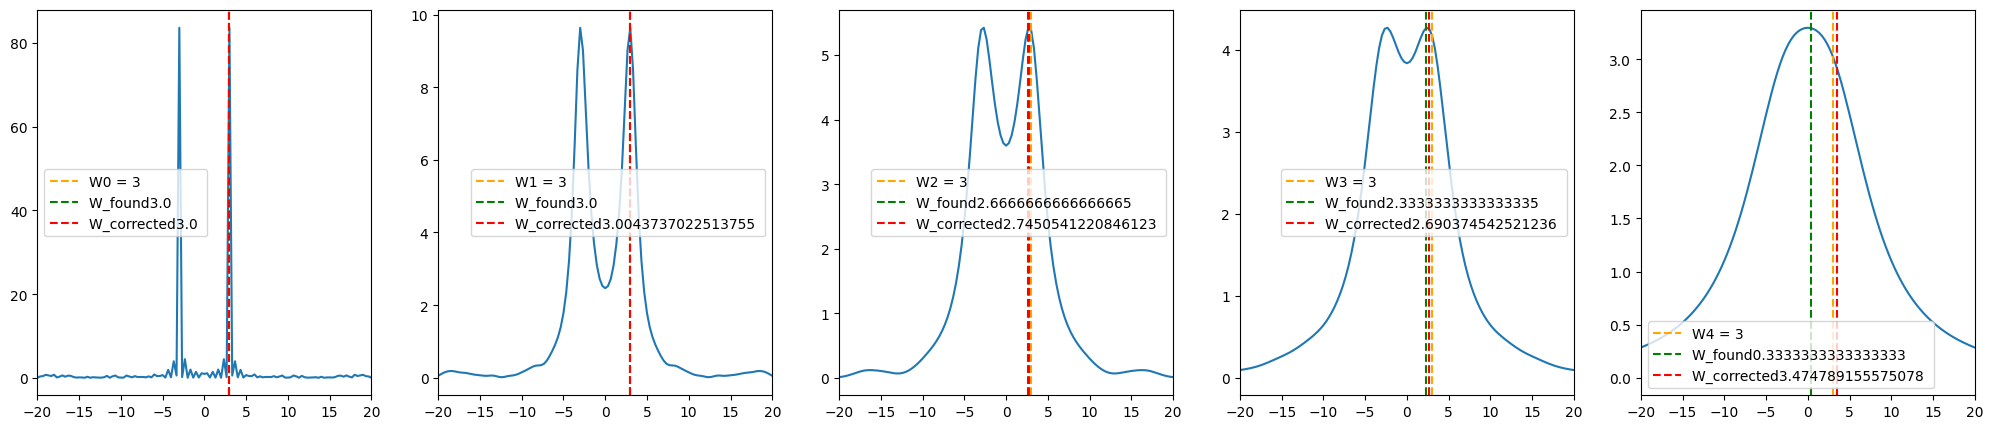

In [245]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Set the range for k

# Create subplots
fig, axs = plt.subplots(1, n, figsize=(5 * n, 5))  # Adjust figsize as needed

# Iterate over each k
for k in range(n):
    extended = ramseyBatch1.get_zi(k)[::-1]
    extended = extended + ramseyBatch1.get_zi(k)
    fft_output_ext = np.fft.fft(extended)

    # Set the sampling rate based on measurements
    sample_rate = measurements / T

    # Compute the positive frequencies for the FFT output
    frequencies_ext = np.fft.fftfreq(2 * len(ramseyBatch1.get_zi(k)), 1 / sample_rate)
    frequencies_ext *= (2 * np.pi)
    positive_indices = np.where(frequencies_ext > 0)
    positive_magnitudes = np.abs(fft_output_ext)[positive_indices]

    paired = sorted(zip(frequencies_ext, fft_output_ext))

    # Unzipping the pairs
    frequencies_ext, fft_output_ext = zip(*paired)

    # Find peaks in the positive magnitudes
    # peaks, _ = find_peaks(positive_magnitudes)
    #
    # # Get the magnitudes of these peaks
    # peak_magnitudes = positive_magnitudes[peaks]
    #
    # # Sort the peaks by their magnitudes in descending order
    # sorted_peak_indices = np.argsort(peak_magnitudes)[::-1]
    # n_highest_peaks = sorted_peak_indices[:3]

    # Plot and annotate results on the respective subplot
    axs[k].plot(frequencies_ext, np.abs(fft_output_ext))
    axs[k].axvline(x=W[k], color='orange', linestyle='--', label=f'W{k} = {W[k]}')

    highest_freq = frequencies[np.argmax(positive_magnitudes)]


    # highest_freq = frequencies_ext[positive_indices][peaks[n_highest_peaks[0]]]
    axs[k].axvline(x=highest_freq, color='green', linestyle='--', label=f'W_found{highest_freq} ')

    a = L[k]

    w_solutions = [
        -np.sqrt(-a ** 2 / 3 + highest_freq ** 2 / 3 - 2 * np.sqrt(
            a ** 4 + a ** 2 * highest_freq ** 2 + highest_freq ** 4) / 3),
        np.sqrt(-a ** 2 / 3 + highest_freq ** 2 / 3 - 2 * np.sqrt(
            a ** 4 + a ** 2 * highest_freq ** 2 + highest_freq ** 4) / 3),
        -np.sqrt(-a ** 2 / 3 + highest_freq ** 2 / 3 + 2 * np.sqrt(
            a ** 4 + a ** 2 * highest_freq ** 2 + highest_freq ** 4) / 3),
        np.sqrt(-(a ** 2) / 3 + (highest_freq ** 2) / 3 + 2 * np.sqrt(
            a ** 4 + (a ** 2) * highest_freq ** 2 + highest_freq ** 4) / 3)
    ]
    axs[k].axvline(x=w_solutions[3], color='red', linestyle='--', label=f'W_corrected{w_solutions[3]} ')

    axs[k].legend()
    axs[k].set_xlim([-20, 20])  # Adjust as needed

# Display the plot
plt.show()


In [352]:
from sympy import symbols, integrate, oo, pi, Abs
a, x, w = symbols('a x w')
f = x * pi * (2 * a / (a**2 + (x - w)**2) + 2 * a / (a**2 + (x + w)**2))
mu = integrate(f, (x, 0, oo))
mu.simplify
print(mu)

-(pi*a - I*pi*w)*log((-pi*a**2 + 2*a*(pi*a - I*pi*w) - pi*w**2)/pi) - (pi*a + I*pi*w)*log((-pi*a**2 + 2*a*(pi*a + I*pi*w) - pi*w**2)/pi) + oo*sign(a)


In [399]:
from sympy import symbols, diff, solve
a, x, w = symbols('a x w')

y_lornz_single = lambda a, x: (a / ((a ** 2 + x ** 2)*np.pi))
X = np.linspace(-100,100,1000)
Y1 = y_lornz_single(3, X)

def m_l_fun(a, y):
    s = 0
    for i in range(len(y)):
        s += (y[i]**2-a**2)/(y[i]**2 + a**2)
    return s
m_l = m_l_fun(a, Y1)

solution = solve(m_l, a)
print(solution)

# print(np.sum(Y1))
# sum = np.sum(Y1)




KeyboardInterrupt: 

4.9835878212576565
Estimated gamma: 5.055834960937505


C:\Users\user\AppData\Local\Temp\ipykernel_26092\1089594854.py:15: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log((gamma / ((gamma ** 2 + data ** 2)*np.sum(Y1)*np.pi))))


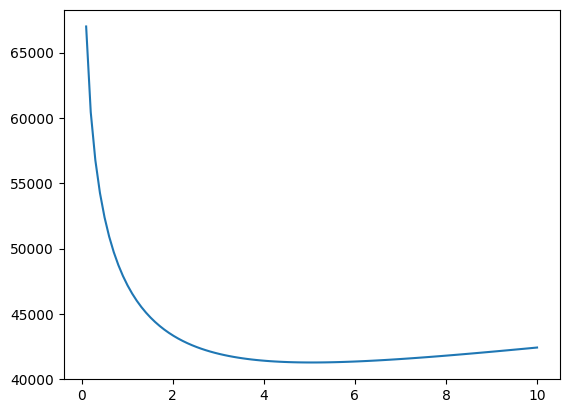

In [140]:
import numpy as np
from scipy.optimize import minimize
X = np.linspace(-1000,1000,10000)
y_lornz_single = lambda a, x: (a / ((a ** 2 + x ** 2)*np.pi))
Y1 = y_lornz_single(5, X)
print(np.sum(Y1))
Y1 = Y1/np.sum(Y1)
samples = np.random.choice(X, size=10000, p=Y1)
#print(np.sum(Y1))
#plt.plot(X,Y1)

def cauchy_log_likelihood(data, x0):
    def neg_log_likelihood(gamma):
        gamma = np.abs(gamma)  # Ensure gamma is positive
        log_likelihood = np.sum(np.log((gamma / ((gamma ** 2 + data ** 2)*np.sum(Y1)*np.pi))))
        return -log_likelihood  # Negative because we minimize

    # Initial guess for gamma using median absolute deviation
    initial_gamma = 3

    # Optimize using a different method (e.g., 'Nelder-Mead')
    result = minimize(neg_log_likelihood, initial_gamma, method='Nelder-Mead')
    gammas = np.linspace(0, 10, 100)
    plt.plot(gammas, [neg_log_likelihood(gamma) for gamma in gammas])
    if result.success:
        return result.x[0]  # The optimal gamma value
    else:
        raise ValueError("Optimization did not converge: " + result.message)


# Example usage
data = samples
x0 = 0  # Replace with your estimated x0
gamma = cauchy_log_likelihood(data, x0)
print("Estimated gamma:", gamma)


In [3]:
y_lornz = lambda a, x, w: np.pi*(2 * a / (a ** 2 + (x - w) ** 2) + 2 * a / (a ** 2 + (x + w) ** 2))
fft_data = gaussian_filter(np.abs(fft_output_ext1), sigma=1)
probs = fft_data / np.sum(fft_data)
samples = np.random.choice(frequencies_ext, size=100000, p=probs)
def cauchy_log_likelihood(data, w):
    def neg_log_likelihood(gamma):
        gamma = np.abs(gamma)  # Ensure gamma is positive
        log_likelihood = np.sum(0.001*np.log(np.pi*(2 * gamma / (gamma ** 2 + (data - w) ** 2) + 2 * gamma / (gamma ** 2 + (data + w) ** 2))))
        return -log_likelihood  # Negative because we minimize

    # Initial guess for gamma using median absolute deviation
    initial_gamma = 5

    # Optimize using a different method (e.g., 'Nelder-Mead')
    result = minimize(neg_log_likelihood, initial_gamma, method='Nelder-Mead')
    gammas = np.linspace(0, 10, 100)
    plt.plot(gammas, [neg_log_likelihood(gamma) for gamma in gammas])
    if result.success:
        return result.x[0]  # The optimal gamma value
    else:
        raise ValueError("Optimization did not converge: " + result.message)

# Example usage
data = samples
gamma = cauchy_log_likelihood(data, 3)
print("Estimated gamma:", gamma)


NameError: name 'gaussian_filter' is not defined

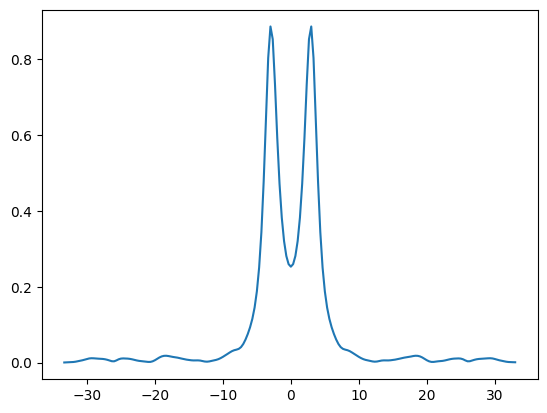

In [247]:
plt.plot(frequencies_ext, fft_data)